In [9]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import sys
import imodels
import imodelsx.process_results
from notebook_helper import calc_mean_std_across_curves
sys.path.append('../experiments/')
results_dir = '../results/'

r = imodelsx.process_results.get_results_df(results_dir)
experiment_filename = '../experiments/01_train_model.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
# r.to_pickle('../results/agg.pkl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 6047/6047 [00:04<00:00, 1309.62it/s]


In [12]:
ravg = []
group_keys = [k for k in imodelsx.process_results.get_main_args_list(experiment_filename='01_train_model.py') if not k == 'seed']
rg = r.groupby(group_keys)
for group_key, group_idx in rg.groups.items():
    g = r.iloc[group_idx]
    numeric_keys = [k for k in list(g.select_dtypes("number")) if not k in group_keys]
    # numeric_keys = ['roc_auc_test', 'stability']
    row = g[numeric_keys].mean()
    for k in group_keys:
        row[k] = g[k].iloc[0]
    try:
        row['instability'] = calc_mean_std_across_curves(g['shape_function_vals_list'].values.tolist())
        ravg.append(row)
    except:
        pass

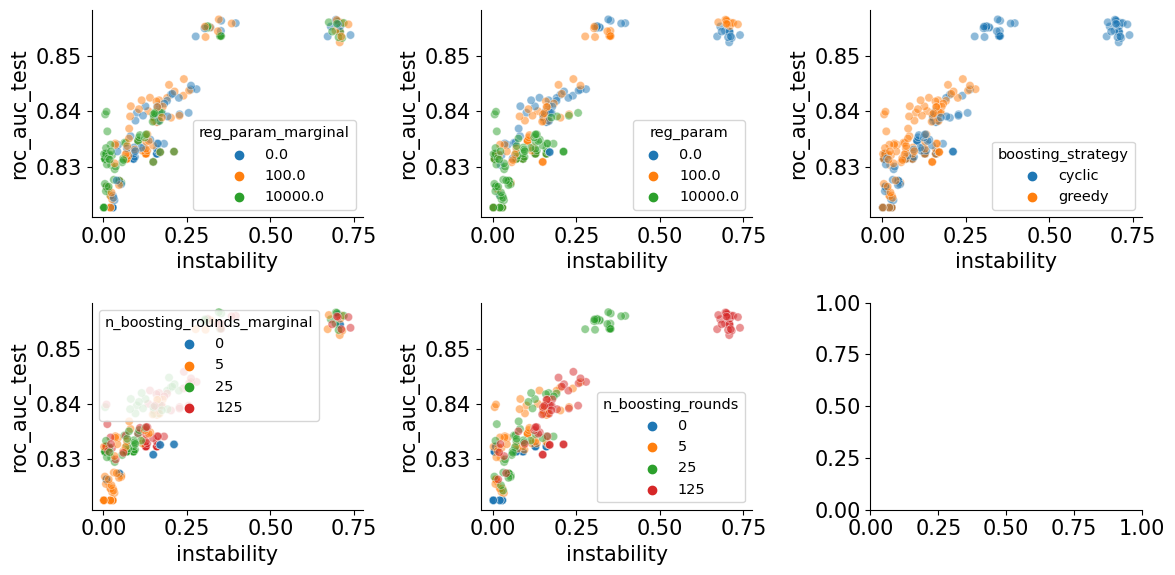

In [37]:
df = pd.DataFrame(ravg)
df = (
    df.groupby([k for k in group_keys if not k == "dataset_name"])[
        ["roc_auc_test", "instability"]
    ]
    .mean()
    .reset_index()
)
# df = df[~((df.n_boosting_rounds == 0) & (df.n_boosting_rounds_marginal == 0))]
df = df[df.roc_auc_test >= 0.8]
# df = df[df.boosting_strategy == 'cyclic']
# df = df[df.fit_linear_marginal == "None"]
# df = df[df.n_boosting_rounds == 0]
# df = df[df.n_boosting_rounds_marginal == 5]
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

kwargs = dict(
    data=df,
    x="instability",
    y="roc_auc_test",
    palette="tab10",
    alpha=0.5,
)
ks = [
    "reg_param_marginal",
    "reg_param",
    "boosting_strategy",
    "n_boosting_rounds_marginal",
    "n_boosting_rounds",
]
for i, k in enumerate(ks):
    ax = axes.flatten()[i]
    sns.scatterplot(
        **kwargs,
        hue=k,
        ax=ax,
    )
    ax.legend(fontsize="x-small", title=k, title_fontsize="x-small")

plt.show()

In [22]:
for val in ['roc_auc_test', 'instability']:
    print(val)
    df = pd.DataFrame(ravg)
    df['reg_param'] = df['reg_param'].astype(str)
    df['reg_param_marginal'] = df['reg_param_marginal'].astype(str)
    means = df.pivot_table(
        index=["boosting_strategy", "n_boosting_rounds", "reg_param"],
        columns=["n_boosting_rounds_marginal", "reg_param_marginal"],
        values=[val],
        aggfunc="mean",
    )
    # replace values <=0.5 with nan
    if val == 'roc_auc_test':
        means[means <= 0.5] = np.nan
    else:
        means[means >= 0.5] = np.nan

    display(means.style.format(precision=2).background_gradient(cmap="RdBu_r", axis=None))

roc_auc_test


instability
